In [1]:
# For reproducability
import os
os.environ['PYTHONHASHSEED'] = '29'
import numpy as np
np.random.seed(29)
import random
random.seed(29)
import tensorflow
tensorflow.random.set_seed(29)

In [2]:
#Importing packages
import pandas as pd
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pysindy as ps

Using TensorFlow backend.


In [3]:
# Knobs 
n_future = 1 # How many steps in the future do I want to predict
n_past = 7 # How many past steps do I want to use to predict n_future
feature_columns = ['CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP', 'PRECIPITATION']

In [4]:
# Load in raw dataset
weather_df_norm = pd.read_csv('dataset/dutch_weather_norm_raw.csv', parse_dates = ['DATE'])

In [5]:
# Define functions
def multivariate_supervised_learning_sindy_1(length, n_future = 1, n_past = 7):
    """
    Input:
    length = length for evaluation
    n_future = future time-steps to be predicted
    n_past = past timesteps to be predicted
    
    Output:
    Train test splits for control variables (X) and target variable (u) as dataframes
    """
    
    if length == 'short':
        length = weather_df_norm[0:732][feature_columns]
    elif length == 'medium':
        length = weather_df_norm[0:7304][feature_columns]
    elif length == 'long':
        length = weather_df_norm[0:21914][feature_columns]
    else:
        print('No proper length accepted')
        return 0
        
    X = []
    y = []
    
    for i in range(n_past, len(length) - n_future + 1):
        X.append(length[i - n_past:i])
        y.append(length[i + n_future - 1: i + n_future]['PRECIPITATION'])
    
    train_len = round(0.5 * len(X))
    val_len = round(0.5 * train_len)
    
    X = np.array(X).reshape((int((len(length) - n_past)), 42))
    y = np.array(y).reshape((int((len(length) - n_past)), 1))
                
    X_train = X[:train_len]
    X_val = X[train_len:train_len + val_len]
    X_test = X[train_len + val_len:]
    
    y_train = y[:train_len]
    y_val = y[train_len:train_len + val_len]
    y_test = y[train_len + val_len:]


    return X_train, X_val, X_test, y_train, y_val, y_test

def multivariate_supervised_learning_sindy_2(length, n_future = 1, n_past = 7):
    """
    Input:
    length = length for evaluation
    n_future = future time-steps to be predicted
    n_past = past timesteps to be predicted
    
    Output:
    Train test splits for control variables (X) and target variable (u) as dataframes
    """
    
    if length == 'short':
        length = weather_df_norm[7:732][feature_columns]
    elif length == 'medium':
        length = weather_df_norm[7:7304][feature_columns]
    elif length == 'long':
        length = weather_df_norm[7:21914][feature_columns]
    else:
        print('No proper length accepted')
        return 0
    
    train_len = round(0.5 * len(length))
    val_len = round(0.5 * train_len)
                
    X_train = length[:train_len][feature_columns[0:-1]]
    X_val = length[train_len:train_len + val_len][feature_columns[0:-1]]
    X_test = length[train_len + val_len:][feature_columns[0:-1]]
    
    y_train = length[:train_len]['PRECIPITATION']
    y_val = length[train_len:train_len + val_len]['PRECIPITATION']
    y_test = length[train_len + val_len:]['PRECIPITATION']
    
    return X_train, X_val, X_test, pd.DataFrame(y_train), pd.DataFrame(y_val), pd.DataFrame(y_test)
    
def multivariate_supervised_learning_lstm(length, n_future = 1, n_past = 7):
    """
    Input:
    length = length for evaluation
    n_future = future time-steps to be predicted
    n_past = past timesteps to be predicted
    
    Output:
    Train test splits for control variables (X) and target variable (u) as numpy arrays
    """
    
    if length == 'short':
        length = weather_df_norm[0:732][feature_columns]
    elif length == 'medium':
        length = weather_df_norm[0:7304][feature_columns]
    elif length == 'long':
        length = weather_df_norm[0:21914][feature_columns]
    else:
        print('No proper length accepted')
        return 0
    
    X = []
    y = []
    
    for i in range(n_past, len(length) - n_future + 1):
        X.append(length[i - n_past:i])
        y.append(length[i + n_future - 1: i + n_future]['PRECIPITATION'])
    
    train_len = round(0.5 * len(X))
    val_len = round(0.5 * train_len)
    
    X_train = np.array(X[:train_len])
    X_val = np.array(X[train_len:train_len + val_len])
    X_test = np.array(X[train_len + val_len:])
    
    y_train = np.array(y[:train_len])
    y_val = np.array(y[train_len:train_len + val_len])
    y_test = np.array(y[train_len + val_len:])

    return X_train, X_val, X_test, y_train, y_val, y_test

## Raw Dataset

### Short Time-series

#### SINDy Trigonometric (excl. lags)

In [6]:
# Create supervised learning problem for SINDy excl. lagged features short dataset
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning_sindy_2('short')

In [7]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.102)
model_trigo_short = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_trigo_short.fit(x = y_train_short.values, u = X_train_short.values)

trigo_short_excl = model_trigo_short.predict(x = y_test_short.values, u = X_test_short.values)

#### LSTM

In [8]:
# Create supervised learning problem LSTM short dataset
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning_lstm('short', n_future = 1, n_past = 7)

In [9]:
# Build LSTM Model
batch_size = 11
epochs = 30
    
model_short = Sequential()
model_short.add(LSTM(25, activation = 'relu', input_shape = (X_train_short.shape[1], X_train_short.shape[2]), return_sequences = False))
model_short.add(Dense(1, activation = 'linear'))
model_short.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_short = model_short.fit(X_train_short, y_train_short, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_short, y_val_short), verbose = 0)

# Predictions on test set
lstm_short = model_short.predict(X_test_short)

#### Graph

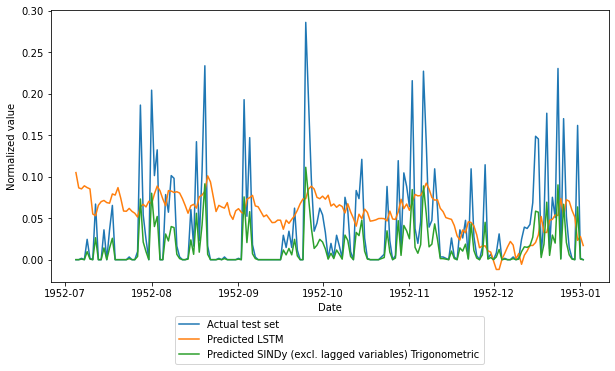

In [10]:
# Plot graphs comparing test set performance
plt.figure(figsize = (10, 5))
plt.xlabel('Date')
plt.ylabel('Normalized value')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], y_test_short, label = 'Actual test set')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], lstm_short, label = 'Predicted LSTM')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], trigo_short_excl, label = 'Predicted SINDy (excl. lagged variables) Trigonometric')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.32))
plt.savefig(f'graphs/raw_short_sindy_vs_lstm.jpeg', bbox_inches='tight')

### Long Time-series

#### SINDy Polynomial (excl. lags)

In [11]:
# Create supervised learning problem for SINDy excl. lagged features long dataset
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning_sindy_2('long')

In [12]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 1)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_long = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_poly_long.fit(x = y_train_long.values, u = X_train_long.values)

# Predict test values
poly_long_excl = model_poly_long.predict(x = y_test_long.values, u = X_test_long.values)

#### SINDy Trigonometric (excl. lags)

In [13]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.149)
model_trigo_long = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_trigo_long.fit(x = y_train_long.values, u = X_train_long.values)

# Predict test values
trigo_long_excl = model_trigo_long.predict(x = y_test_long.values, u = X_test_long.values)

#### SINDy Polynomial (incl. lags)

In [14]:
# Create supervised learning problem for SINDy incl. lagged features long dataset
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning_sindy_1('long')

In [15]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 1)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_long = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_poly_long.fit(x = y_train_long, u = X_train_long)

# Predict test values
poly_long_incl = model_poly_long.predict(x = y_test_long, u = X_test_long)

#### LSTM

In [16]:
# Create supervised learning problem LSTM long dataset
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning_lstm('long', n_future = 1, n_past = 7)

In [17]:
# Build LSTM Model
batch_size = 86
epochs = 50
    
model_long = Sequential()
model_long.add(LSTM(25, activation = 'relu', input_shape = (X_train_long.shape[1], X_train_long.shape[2]), return_sequences = False))
model_long.add(Dense(1, activation = 'linear'))
model_long.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_long = model_long.fit(X_train_long, y_train_long, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_long, y_val_long), verbose = 0)

# Predictions on test set
lstm_long = model_long.predict(X_test_long)

#### Graph

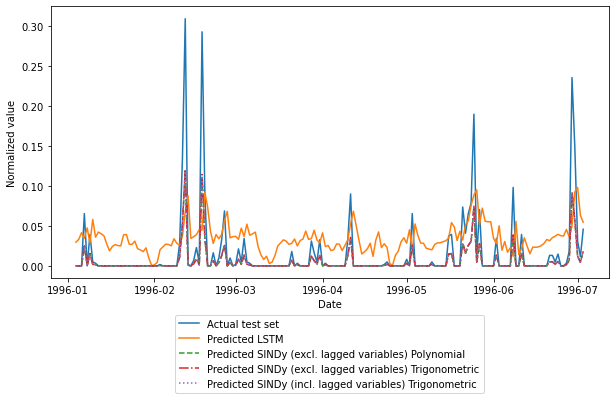

In [18]:
# Plot graphs comparing test set performance
plt.figure(figsize = (10, 5))
plt.xlabel('Date')
plt.ylabel('Normalized value')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], y_test_long[0:182], label = 'Actual test set', linestyle = '-')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], lstm_long[0:182], label = 'Predicted LSTM')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], poly_long_excl[0:182], label = 'Predicted SINDy (excl. lagged variables) Polynomial', linestyle = '--')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], trigo_long_excl[0:182], label = 'Predicted SINDy (excl. lagged variables) Trigonometric', linestyle = '-.')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], poly_long_incl[0:182], label = 'Predicted SINDy (incl. lagged variables) Trigonometric', linestyle = ':')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.44))
plt.savefig(f'graphs/raw_long_sindy_vs_lstm.jpeg', bbox_inches='tight')

## Denoised Dataset

In [19]:
# Load denoised dataset
weather_df_norm = pd.read_csv('dataset/dutch_weather_norm_denoised.csv', parse_dates = ['DATE'])

### Short Time-series

#### SINDy Polynomial (excl. lags)

In [20]:
# Create supervised learning problem for SINDy excl. lagged features short dataset
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning_sindy_2('short')

In [21]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 1)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_short = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_poly_short.fit(x = y_train_short.values, u = X_train_short.values)

# Predict test values
poly_short_excl = model_poly_short.predict(x = y_test_short.values, u = X_test_short.values)

#### SINDy Trigonometric (excl. lags)

In [22]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.149)
model_trigo_short = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_trigo_short.fit(x = y_train_short.values, u = X_train_short.values)

# Predict test values
trigo_short_excl = model_trigo_short.predict(x = y_test_short.values, u = X_test_short.values)

#### SINDy Combined (excl. lags)

In [23]:
# Create model for prediction
combined_library = ps.PolynomialLibrary(degree = 3) + ps.FourierLibrary()

optimizer = ps.STLSQ(threshold = 0.149)
model_combined_short = ps.SINDy(feature_library = combined_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_combined_short.fit(x = y_train_short.values, u = X_train_short.values)

# Predict test values
combined_short_excl = model_combined_short.predict(x = y_test_short.values, u = X_test_short.values)

#### SINDy Polynomial (incl. lags)

In [24]:
# Create supervised learning problem for SINDy incl. lagged features short dataset
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning_sindy_1('short')

In [25]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 2)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_short = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION (T)',
                                                                            'CLOUDINESS (T-7)', 'HUMIDITY (T-7)', 'MAX_TEMP (T-7)', 'MIN_TEMP (T-7)', 'MEAN_TEMP (T-7)', 'PRECIPITATION (T-7)',
                                                                            'CLOUDINESS (T-6)', 'HUMIDITY (T-6)', 'MAX_TEMP (T-6)', 'MIN_TEMP (T-6)', 'MEAN_TEMP (T-6)', 'PRECIPITATION (T-6)',
                                                                            'CLOUDINESS (T-5)', 'HUMIDITY (T-5)', 'MAX_TEMP (T-5)', 'MIN_TEMP (T-5)', 'MEAN_TEMP (T-5)', 'PRECIPITATION (T-5)',
                                                                            'CLOUDINESS (T-4)', 'HUMIDITY (T-4)', 'MAX_TEMP (T-4)', 'MIN_TEMP (T-4)', 'MEAN_TEMP (T-4)', 'PRECIPITATION (T-4)',
                                                                            'CLOUDINESS (T-3)', 'HUMIDITY (T-3)', 'MAX_TEMP (T-3)', 'MIN_TEMP (T-3)', 'MEAN_TEMP (T-3)', 'PRECIPITATION (T-3)',
                                                                            'CLOUDINESS (T-2)', 'HUMIDITY (T-2)', 'MAX_TEMP (T-2)', 'MIN_TEMP (T-2)', 'MEAN_TEMP (T-2)', 'PRECIPITATION (T-2)',
                                                                            'CLOUDINESS (T-1)', 'HUMIDITY (T-1)', 'MAX_TEMP (T-1)', 'MIN_TEMP (T-1)', 'MEAN_TEMP (T-1)', 'PRECIPITATION (T-1)',], discrete_time = True, optimizer = optimizer)

model_poly_short.fit(x = y_train_short, u = X_train_short)

# Predict test values
poly_short_incl = model_poly_short.predict(x = y_test_short, u = X_test_short)

#### LSTM

In [26]:
# Create supervised learning problem LSTM short dataset
X_train_short, X_val_short, X_test_short, y_train_short, y_val_short, y_test_short = multivariate_supervised_learning_lstm('short', n_future = 1, n_past = 7)

In [27]:
# Build LSTM Model
batch_size = 11
epochs = 60
    
model_short = Sequential()
model_short.add(LSTM(25, activation = 'relu', input_shape = (X_train_short.shape[1], X_train_short.shape[2]), return_sequences = False))
model_short.add(Dense(1, activation = 'linear'))
model_short.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_short = model_short.fit(X_train_short, y_train_short, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_short, y_val_short), verbose = 0)

# Predictions on test set
lstm_short = model_short.predict(X_test_short)

#### Graph

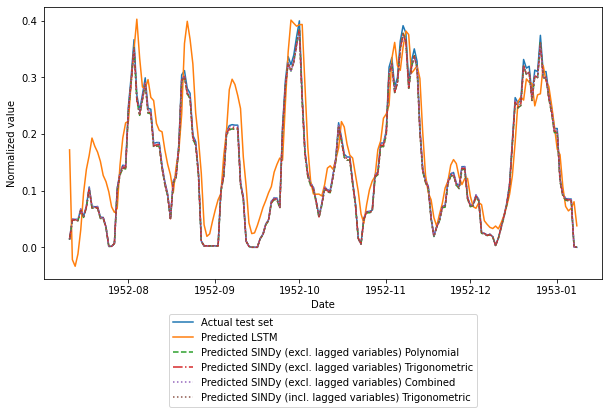

In [28]:
# Plot graphs comparing test set performance
plt.figure(figsize = (10, 5))
plt.xlabel('Date')
plt.ylabel('Normalized value')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], y_test_short, label = 'Actual test set', linestyle = '-')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], lstm_short, label = 'Predicted LSTM')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], poly_short_excl, label = 'Predicted SINDy (excl. lagged variables) Polynomial', linestyle = '--')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], trigo_short_excl, label = 'Predicted SINDy (excl. lagged variables) Trigonometric', linestyle = '-.')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], combined_short_excl, label = 'Predicted SINDy (excl. lagged variables) Combined', linestyle = ':')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_short) + len(y_val_short) : n_past + len(y_train_short) + len(y_val_short) + len(y_test_short)], poly_short_incl, label = 'Predicted SINDy (incl. lagged variables) Trigonometric', linestyle = ':')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.49))
plt.savefig(f'graphs/denoised_short_sindy_vs_lstm.jpeg', bbox_inches='tight')

### Long Time-series

#### SINDy Polynomial (excl. lags)

In [29]:
# Create supervised learning problem for SINDy excl. lagged features long dataset
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning_sindy_2('long')

In [30]:
# Create model for prediction
poly_library = ps.PolynomialLibrary(degree = 1)
optimizer = ps.STLSQ(threshold = 0.149)
model_poly_long = ps.SINDy(feature_library = poly_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_poly_long.fit(x = y_train_long.values, u = X_train_long.values)

poly_long_excl = model_poly_long.predict(x = y_test_long.values, u = X_test_long.values)

#### SINDy Trigonometric (excl. lags)

In [31]:
# Create model for prediction
trigo_library = ps.FourierLibrary()
optimizer = ps.STLSQ(threshold = 0.149)
model_trigo_long = ps.SINDy(feature_library = trigo_library, feature_names = ['PRECIPITATION', 'CLOUDINESS', 'HUMIDITY', 'MAX_TEMP', 'MIN_TEMP', 'MEAN_TEMP'], discrete_time = True, optimizer = optimizer)

model_trigo_long.fit(x = y_train_long.values, u = X_train_long.values)

# Predict test values
trigo_long_excl = model_trigo_long.predict(x = y_test_long.values, u = X_test_long.values)

#### LSTM

In [32]:
# Create supervised learning problem LSTM long dataset
X_train_long, X_val_long, X_test_long, y_train_long, y_val_long, y_test_long = multivariate_supervised_learning_lstm('long', n_future = 1, n_past = 7)

In [33]:
# Build LSTM Model
batch_size = 86
epochs = 100
    
model_long = Sequential()
model_long.add(LSTM(25, activation = 'relu', input_shape = (X_train_long.shape[1], X_train_long.shape[2]), return_sequences = False))
model_long.add(Dense(1, activation = 'linear'))
model_long.compile(optimizer = 'RMSprop', loss = 'mse')

#Initiate early stopping
callback = EarlyStopping(monitor = 'mse', patience = 3)

#Fit model
history_long = model_long.fit(X_train_long, y_train_long, epochs = epochs, batch_size = batch_size, shuffle = False, validation_data = (X_val_long, y_val_long), verbose = 0)

# Predictions on test set
lstm_long = model_long.predict(X_test_long)

#### Graph

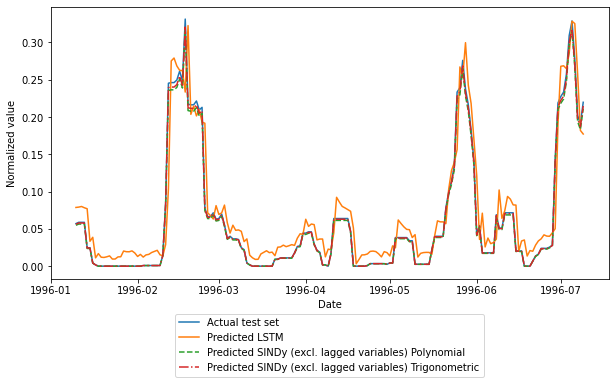

In [34]:
# Plot graphs comparing test set performance
plt.figure(figsize = (10, 5))
plt.xlabel('Date')
plt.ylabel('Normalized value')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], y_test_long[0:182], label = 'Actual test set', linestyle = '-')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], lstm_long[0:182], label = 'Predicted LSTM')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], poly_long_excl[0:182], label = 'Predicted SINDy (excl. lagged variables) Polynomial', linestyle = '--')
plt.plot(weather_df_norm['DATE'][n_past + len(y_train_long) + len(y_val_long) : n_past + len(y_train_long) + len(y_val_long) + len(y_test_long)][0:182], trigo_long_excl[0:182], label = 'Predicted SINDy (excl. lagged variables) Trigonometric', linestyle = '-.')
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5,-0.38))
plt.savefig(f'graphs/denoised_long_sindy_vs_lstm.jpeg', bbox_inches='tight')